<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🍾Garbage Classification (Pytorch)🍶 </div>

![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">📚Importing Libraries📚 </div>

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

<div class="text_cell_render border-box-sizing rendered_html">
<div class="alert alert-block alert-success" style="margin: 20px; padding: 20px; border-radius: 10px; border: 2px solid #4CAF50; background-color: #E6F7E2;">
    <b>📂 Libraries:</b> Successfully import the recquired library
</div>
</div>

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">📚Reading Dataset📚 </div>

In [2]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">🔥Transformation🔥 </div>

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


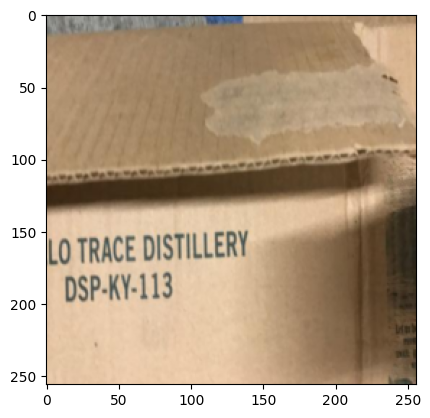

In [5]:
img, label = dataset[12]
show_sample(img, label)

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">🔥Loading And Spliting Data🔥 </div>

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

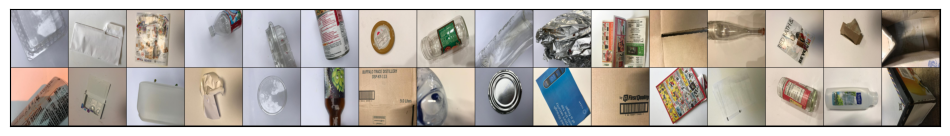

In [11]:
show_batch(train_dl)

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">🔥Model Base🔥 </div>

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">🔥Porting To GPU🔥 </div>

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">🔥Training The Model🔥 </div>

This is the function for fitting the model.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(ResNet(), device)

In [19]:
evaluate(model, val_dl)

{'val_loss': 1.800401210784912, 'val_acc': 0.1302083283662796}

Let's start training the model:

In [20]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4669, val_loss: 1.2838, val_acc: 0.8108
Epoch 2: train_loss: 1.1891, val_loss: 1.1717, val_acc: 0.9132
Epoch 3: train_loss: 1.0945, val_loss: 1.1384, val_acc: 0.9097
Epoch 4: train_loss: 1.0729, val_loss: 1.1262, val_acc: 0.9323
Epoch 5: train_loss: 1.0635, val_loss: 1.1249, val_acc: 0.9392
Epoch 6: train_loss: 1.0623, val_loss: 1.1204, val_acc: 0.9375
Epoch 7: train_loss: 1.0591, val_loss: 1.1065, val_acc: 0.9479
Epoch 8: train_loss: 1.0542, val_loss: 1.1053, val_acc: 0.9306


<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">💹Model Training Graph📈 </div>

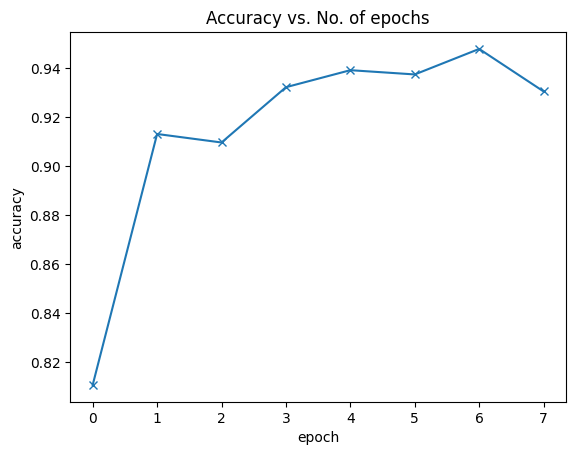

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

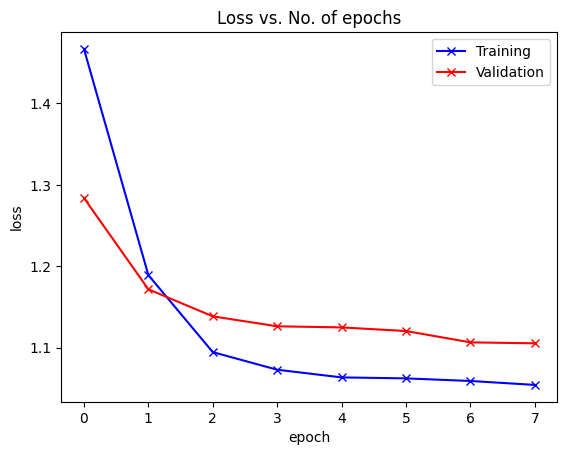

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">📷Visualizing Prediction📷</div>

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Label: metal , Predicted: metal


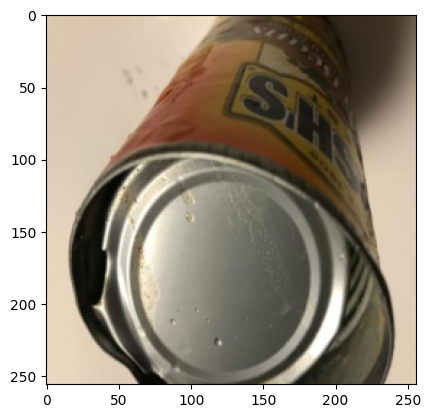

In [24]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


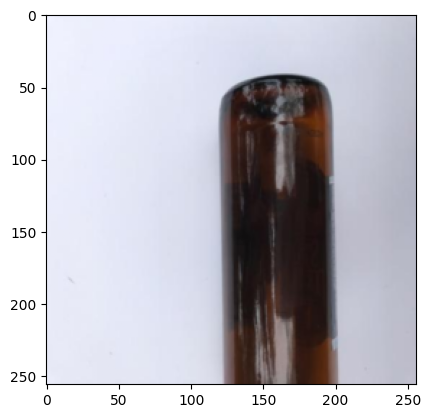

In [25]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


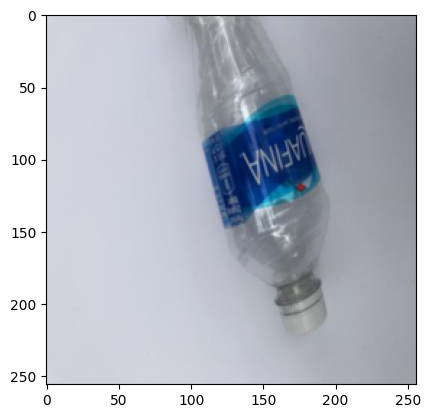

In [26]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

<div class="text_cell_render border-box-sizing rendered_html">
  <div class="alert alert-block alert-info" style="margin: 20px; padding: 20px; border-radius: 10px; border: 2px solid #17a2b8; background-color: #d1ecf1;">
      
# Conclusion:
<br><br>
Our model successfully classifies garbage with an impressive **95% accuracy**!
<br><br>
It's exciting to see the model's predictions on the test set performing so well. It also works effectively on external images!
<br><br>
Feel free to experiment with more images to explore the results further.
<br><br>
If you enjoyed this notebook, please consider upvoting! Additionally, check out some of my other works on Kaggle:
<br><br>

  </div>
</div>


<div class="alert alert-block alert-info" style="margin: 20px; padding: 20px; border-radius: 10px; border: 2px solid #17a2b8; background-color: #f3e8ff;">
      
  If you enjoyed this notebook, please consider giving it an upvote! Here are some of my other works on Kaggle that you might find interesting:

  <br><br>
  - **Automating the Machine Learning Workflow**: [AutoXGB: XGBoost + Optuna](https://www.kaggle.com/code/endofnight17j03/plate-defect-89-xgboost-catboost)
  <br><br>
  - **Working with CatBoost**: [Bank Churn Analysis](https://kaggle.com/code/endofnight17j03/bank-churn-xgboost-catboost)
  <br><br>
  - **Working with Voting**: [Obesity Risk Prediction (92% accuracy with Voting and LGBM)](https://www.kaggle.com/code/endofnight17j03/obesityrisk-92-voting-lgbm)
  <br><br>

  Thank you for your support! 👍😁

</div>
